In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate, Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
from IPython.display import Image
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomContrast, Rescaling

In [1]:
! unzip /content/drive/MyDrive/Combined_Dataset.zip
dataset_dir = "/content/content/AIRecognition"

Streaming output truncated to the last 5000 lines.
  inflating: content/AIRecognition/fake/fake-v2/13943.png  
  inflating: content/AIRecognition/fake/fake-v2/2587.jpg  
  inflating: content/AIRecognition/fake/fake-v2/11963.jpg  
  inflating: content/AIRecognition/fake/fake-v2/20878.png  
  inflating: content/AIRecognition/fake/fake-v2/13839.png  
  inflating: content/AIRecognition/fake/fake-v2/19956.png  
  inflating: content/AIRecognition/fake/fake-v2/22093.png  
  inflating: content/AIRecognition/fake/fake-v2/2704.jpg  
  inflating: content/AIRecognition/fake/fake-v2/16898.png  
  inflating: content/AIRecognition/fake/fake-v2/20703.png  
  inflating: content/AIRecognition/fake/fake-v2/23931.png  
  inflating: content/AIRecognition/fake/fake-v2/17039.png  
  inflating: content/AIRecognition/fake/fake-v2/2647.jpg  
  inflating: content/AIRecognition/fake/fake-v2/24691.png  
  inflating: content/AIRecognition/fake/fake-v2/19245.png  
  inflating: content/AIRecognition/fake/fake-v2/1372

In [6]:
img_height = 224
img_width = 224
batch_size = 100

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  shuffle=True,
  subset="training",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
    RandomRotation(0.2),  # Randomly rotate images by 20%
    RandomZoom(0.2),  # Randomly zoom into images
    RandomContrast(0.2),  # Randomly adjust contrast
])

augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

class_names = train_ds.class_names

Found 27548 files belonging to 2 classes.
Using 22039 files for training.
Found 27548 files belonging to 2 classes.
Using 5509 files for validation.


In [7]:
# Building the Transfer Learning model using EfficientNetV2B0
EfficientNet_base_model = tf.keras.applications.EfficientNetV2B0(
    include_top = False,
    weights = 'imagenet',
    input_shape = (img_height, img_width, 3),
)
EfficientNet_base_model.trainable = True

inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = EfficientNet_base_model(inputs, training = False)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = GlobalAveragePooling2D()(x)
outputs = Dense(1, activation='sigmoid')(x)
EfficientNet_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
EfficientNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

EfficientNet_model.summary()

24274472/24274472 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 64)          737344    
                                                                 
 global_average_pooling2d (  (None, 64)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                              

In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

EfficientNet_model_history = EfficientNet_model.fit(
    augmented_train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
EfficientNet_model.save('EfficientNet_arch4')

Epoch 1/100
221/221 [==============================] - 404s 2s/step - loss: 0.3469 - accuracy: 0.8637 - precision: 0.8377 - recall: 0.7599 - val_loss: 0.1644 - val_accuracy: 0.9405 - val_precision: 0.9193 - val_recall: 0.9117
Epoch 2/100
221/221 [==============================] - 347s 2s/step - loss: 0.1805 - accuracy: 0.9313 - precision: 0.9185 - recall: 0.8831 - val_loss: 0.1474 - val_accuracy: 0.9465 - val_precision: 0.9237 - val_recall: 0.9251
Epoch 3/100
221/221 [==============================] - 347s 2s/step - loss: 0.1502 - accuracy: 0.9419 - precision: 0.9296 - recall: 0.9035 - val_loss: 0.1828 - val_accuracy: 0.9305 - val_precision: 0.9804 - val_recall: 0.8199
Epoch 4/100
221/221 [==============================] - 359s 2s/step - loss: 0.1455 - accuracy: 0.9421 - precision: 0.9306 - recall: 0.9028 - val_loss: 0.1550 - val_accuracy: 0.9468 - val_precision: 0.9721 - val_recall: 0.8748
Epoch 5/100
221/221 [==============================] - 348s 2s/step - loss: 0.1274 - accuracy: 0

In [9]:
val_loss, val_accuracy, val_precision, val_recall = EfficientNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

56/56 [==============================] - 35s 540ms/step - loss: 0.1202 - accuracy: 0.9586 - precision: 0.9415 - recall: 0.9415
Val Loss: 0.1202
Val Accuracy: 0.9586
Val Precision: 0.9415
Val Recall: 0.9415


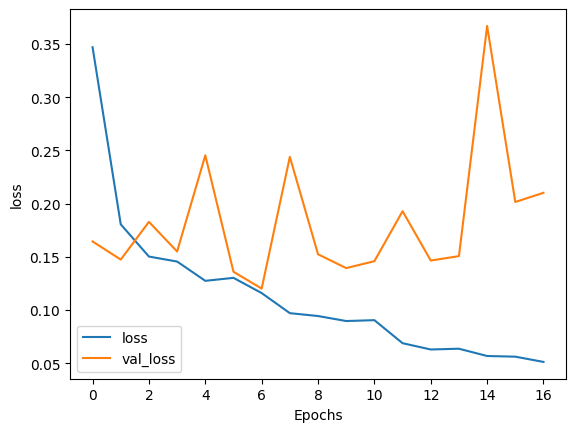

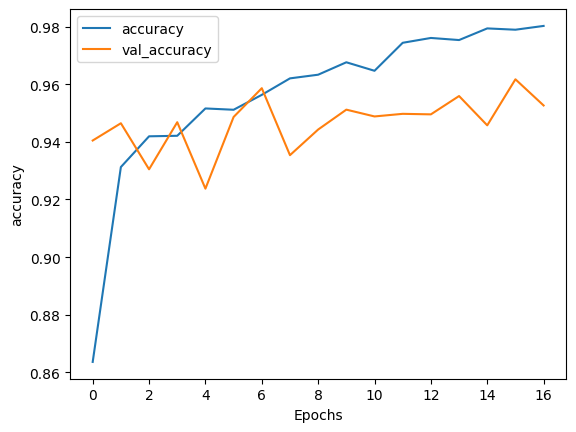

In [11]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_metrics(EfficientNet_model_history, 'loss')
plot_metrics(EfficientNet_model_history, 'accuracy')